# Mountain Car v0 - Q Learning - Modified Reward

In [1]:
import ipympl
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os


In [2]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)
PATH = glob.glob(os.path.expanduser('~/tboardlogs/'))[0]
writer = SummaryWriter('{}{}'.format(PATH, datetime.now().strftime('%b%d_%H-%M-%S')))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Running the environment with random actions produces no successful episodes in a run of 1000 episodes.  The agent receives a reward of -1 for every step that does not end in a successful completion of the episode but we can modify the policy learning to reward progress and encourage the agent to move further and further to the right of the environment.

Furthest Position: -0.164068288377174


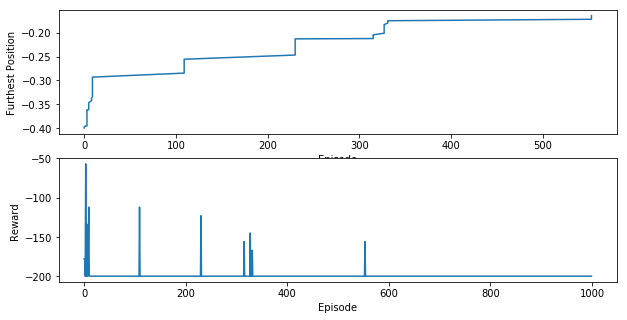

successful episodes: 0


In [3]:
max_position = -.4
positions = np.ndarray([0,2])
rewards = []
successful = []
for episode in range(1000):
    running_reward = 0
    env.reset()
    done = False
    for i in range(200):
        state, reward, done, _ = env.step(np.random.randint(0,3))
        # Give a reward for reaching a new maximum position
        if state[0] > max_position:
            max_position = state[0]
            positions = np.append(positions, [[episode, max_position]], axis=0)
            running_reward += 10
        else:
            running_reward += reward
        if done: 
            if state[0] >= 0.5:
                successful.append(episode)
            rewards.append(running_reward)
            break

print('Furthest Position: {}'.format(max_position))
plt.figure(1, figsize=[10,5])
plt.subplot(211)
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')
plt.subplot(212)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('successful episodes: {}'.format(np.count_nonzero(successful)))

## Policy
We'll use a small neural network with 100 hidden units to learn our policy.

In [4]:
# I tried different weight initializations but found they did not perform well.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)
    


We will use the Q-Learning update equation to update our action value function based on the reward for the agent's action and the maximum future action value function one step in the future.  The portion inside the brackets becomes the loss function for our neural network where $Q(s_t,a_t)$ is the output of our network and $ r_t + \gamma \max\limits_{a} Q(s_{t+1},a_{t+1}) $ is the target Q value as well as the label for our neural net turning the problem into a supervised learning problem.

$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big[r_t + \gamma \max\limits_{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big]  \tag{Q-Learning}$$

In [5]:
# Parameters
steps = 200
state = env.reset()
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 1000
max_position = -0.4
learning_rate = 0.001
successes = 0
position = []

# Initialize Policy
policy = Policy()
#policy.apply(weights_init)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()

    for s in range(steps):
        # Uncomment to render environment
        #if episode % 100 == 0 and episode > 0:
        #    env.render()
        
        # Get first action value function
        Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        state_1, reward, done, _ = env.step(action)
        
        # Adjust reward based on car position
        reward = state_1[0] + 0.5
        
        # Keep track of max position
        if state_1[0] > max_position:
            max_position = state_1[0]
            writer.add_scalar('data/max_position', max_position, episode)
        
        # Adjust reward for task completion
        if state_1[0] >= 0.5:
            reward += 1
        
        # Find max Q for t+1 state
        Q1 = policy(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target)
        Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        policy.zero_grad()
        loss.backward()
        optimizer.step()

        episode_loss += loss.item()
        episode_reward += reward
        
        if done:
            if state_1[0] >= 0.5:
                # On successful epsisodes, adjust the following parameters

                # Adjust epsilon
                epsilon *= .95
                writer.add_scalar('data/epsilon', epsilon, episode)

                # Adjust learning rate
                scheduler.step()
                #optimizer.param_groups[0]['lr'] = max(optimizer.param_groups[0]['lr'], 1.0e-4)
                writer.add_scalar('data/learning_rate', optimizer.param_groups[0]['lr'], episode)

                # Record successful episode
                successes += 1
                writer.add_scalar('data/cumulative_success', successes, episode)
                writer.add_scalar('data/success', 1, episode)
            
            elif state_1[0] < 0.5:
                writer.add_scalar('data/success', 0, episode)
            
            # Record history
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
            writer.add_scalar('data/episode_loss', episode_loss, episode)
            writer.add_scalar('data/episode_reward', episode_reward, episode)
            weights = np.sum(np.abs(policy.l2.weight.data.numpy()))+np.sum(np.abs(policy.l1.weight.data.numpy()))
            writer.add_scalar('data/weights', weights, episode)
            writer.add_scalar('data/position', state_1[0], episode)
            position.append(state_1[0])

            break
        else:
            state = state_1
            
writer.close()
print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

100%|██████████| 1000/1000 [00:59<00:00, 16.74it/s]

successful episodes: 651 - 65.1000%


## Plot Results
Around episode 330 the agent begins to successfully complete episodes, and around episode 370, the agent completes almost every episode successfully.

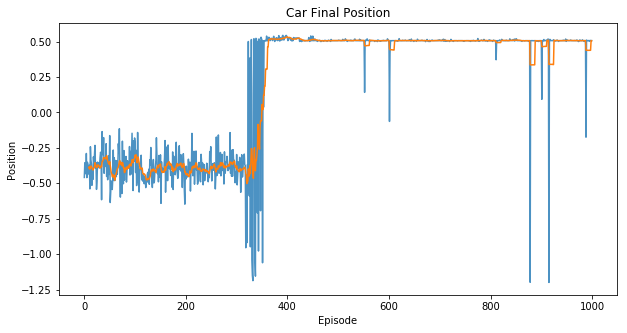

In [6]:
plt.figure(2, figsize=[10,5])
p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Final Position - Modified.png')
plt.show()

<iframe width="900" position="800" frameborder="0" scrolling="no" src="//plot.ly/~ts1829/22.embed"></iframe>

## Visualize Policy
The learned policy can be clearly visualized in the plot below.  The agent learns to move left when the car's velocity is negative and then switch directions when the car's velocity becomes positive with a few position and velocity combinations on the far left of the environment where the agent will do nothing.

In [7]:
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    _, temp = torch.max(policy(Variable(torch.from_numpy(np.array([X[i],Y[i]]))).type(torch.FloatTensor)), dim =-1)
    z = temp.item()
    Z.append(z)
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

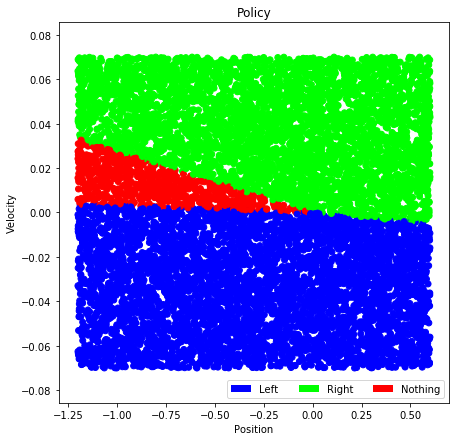

In [8]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
fig.savefig('Policy - Modified.png')
plt.show()